<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-Tolabmc/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [4]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [5]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        # TODO: define the transformation for the train set (with data augmentation)
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    else:
          train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
          ])
    return train_transform, test_transform


## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [6]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    # TODO: download the FashionMNIST dataset
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', download=True,train=True, transform=train_transform)
    test_dataset  = torchvision.datasets.FashionMNIST(root='./data', download=True, train=False, transform=test_transform)

    # TODO: create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.68MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.3MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [7]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, padding= 1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels= 64, kernel_size=3, padding= 1)
        self.pool  = nn.MaxPool2d(2,2) # Remember that a kernel size and stride of 2 each effectively halves the size of the image!



        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(256*7*7, 512)
        self.fc2 = nn.Linear(512, 10)

        if self.useRegularization:
            self.dropout = nn.Dropout(dropout_prob)


    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        # Use regularisation layers as you see fit

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        out = self.fc2(x)
        return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [8]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [9]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)


In [10]:
epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.306062  [   64/60000]
loss: 0.505509  [ 6464/60000]
loss: 0.464837  [12864/60000]
loss: 0.433028  [19264/60000]
loss: 0.416002  [25664/60000]
loss: 0.182344  [32064/60000]
loss: 0.270526  [38464/60000]
loss: 0.294715  [44864/60000]
loss: 0.246793  [51264/60000]
loss: 0.333372  [57664/60000]


Epochs:  20%|██        | 1/5 [00:31<02:07, 31.84s/it]

Train Error: 
 Accuracy: 91.5%, Avg loss: 0.227668 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.271934 

Epoch 2:

loss: 0.181211  [   64/60000]
loss: 0.258358  [ 6464/60000]
loss: 0.181554  [12864/60000]
loss: 0.162814  [19264/60000]
loss: 0.178980  [25664/60000]
loss: 0.227726  [32064/60000]
loss: 0.115074  [38464/60000]
loss: 0.195700  [44864/60000]
loss: 0.180469  [51264/60000]
loss: 0.080589  [57664/60000]


Epochs:  40%|████      | 2/5 [01:02<01:34, 31.41s/it]

Train Error: 
 Accuracy: 93.3%, Avg loss: 0.181680 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.238013 

Epoch 3:

loss: 0.219534  [   64/60000]
loss: 0.163376  [ 6464/60000]
loss: 0.180574  [12864/60000]
loss: 0.175182  [19264/60000]
loss: 0.154035  [25664/60000]
loss: 0.142467  [32064/60000]
loss: 0.076189  [38464/60000]
loss: 0.102387  [44864/60000]
loss: 0.132564  [51264/60000]
loss: 0.199372  [57664/60000]


Epochs:  60%|██████    | 3/5 [01:33<01:02, 31.20s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.118186 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.205781 

Epoch 4:

loss: 0.092626  [   64/60000]
loss: 0.079984  [ 6464/60000]
loss: 0.077049  [12864/60000]
loss: 0.143096  [19264/60000]
loss: 0.126588  [25664/60000]
loss: 0.061739  [32064/60000]
loss: 0.100716  [38464/60000]
loss: 0.106265  [44864/60000]
loss: 0.138079  [51264/60000]
loss: 0.108054  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:05<00:31, 31.23s/it]

Train Error: 
 Accuracy: 97.1%, Avg loss: 0.090740 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.212737 

Epoch 5:

loss: 0.109620  [   64/60000]
loss: 0.073021  [ 6464/60000]
loss: 0.056024  [12864/60000]
loss: 0.036069  [19264/60000]
loss: 0.181266  [25664/60000]
loss: 0.061287  [32064/60000]
loss: 0.078244  [38464/60000]
loss: 0.068854  [44864/60000]
loss: 0.182731  [51264/60000]
loss: 0.114102  [57664/60000]


Epochs: 100%|██████████| 5/5 [02:36<00:00, 31.37s/it]

Train Error: 
 Accuracy: 97.7%, Avg loss: 0.064645 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.226471 

Done training!


Plotting metrics

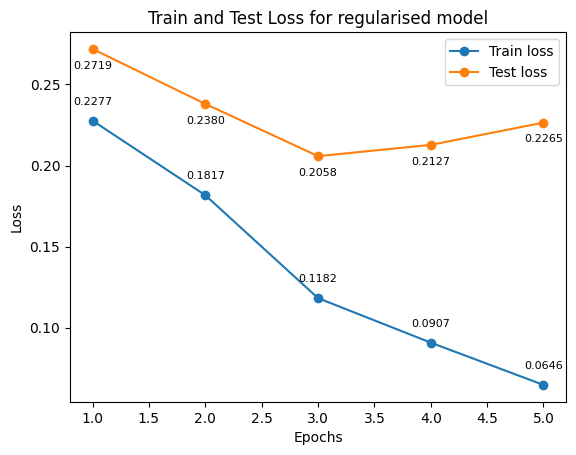

In [11]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

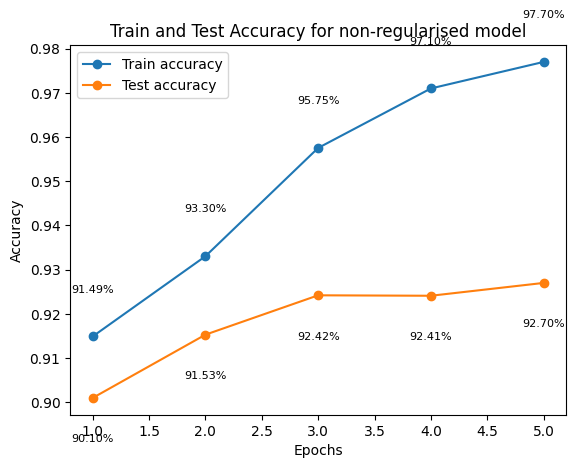

In [12]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [22]:
# Apply only data augmentation
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion().to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.303705  [   64/60000]
loss: 0.424441  [ 6464/60000]
loss: 0.586060  [12864/60000]
loss: 0.261309  [19264/60000]
loss: 0.439620  [25664/60000]
loss: 0.329667  [32064/60000]
loss: 0.382888  [38464/60000]
loss: 0.323963  [44864/60000]
loss: 0.442283  [51264/60000]
loss: 0.328436  [57664/60000]


Epochs:  10%|█         | 1/10 [00:50<07:36, 50.71s/it]

Train Error: 
 Accuracy: 88.8%, Avg loss: 0.308851 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.306445 

Epoch 2:

loss: 0.349322  [   64/60000]
loss: 0.344646  [ 6464/60000]
loss: 0.195427  [12864/60000]
loss: 0.174397  [19264/60000]
loss: 0.349591  [25664/60000]
loss: 0.352350  [32064/60000]
loss: 0.563366  [38464/60000]
loss: 0.154689  [44864/60000]
loss: 0.181159  [51264/60000]
loss: 0.213408  [57664/60000]


Epochs:  20%|██        | 2/10 [01:38<06:30, 48.78s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.230153 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.241286 

Epoch 3:

loss: 0.092326  [   64/60000]
loss: 0.179748  [ 6464/60000]
loss: 0.279200  [12864/60000]
loss: 0.356556  [19264/60000]
loss: 0.270243  [25664/60000]
loss: 0.269792  [32064/60000]
loss: 0.159462  [38464/60000]
loss: 0.115027  [44864/60000]
loss: 0.205338  [51264/60000]
loss: 0.214616  [57664/60000]


Epochs:  30%|███       | 3/10 [02:24<05:34, 47.83s/it]

Train Error: 
 Accuracy: 92.7%, Avg loss: 0.202988 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.239045 

Epoch 4:

loss: 0.183894  [   64/60000]
loss: 0.286663  [ 6464/60000]
loss: 0.145497  [12864/60000]
loss: 0.334907  [19264/60000]
loss: 0.199318  [25664/60000]
loss: 0.211727  [32064/60000]
loss: 0.136684  [38464/60000]
loss: 0.222281  [44864/60000]
loss: 0.194984  [51264/60000]
loss: 0.216920  [57664/60000]


Epochs:  40%|████      | 4/10 [03:09<04:40, 46.71s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.194288 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.220016 

Epoch 5:

loss: 0.204874  [   64/60000]
loss: 0.141926  [ 6464/60000]
loss: 0.337682  [12864/60000]
loss: 0.350746  [19264/60000]
loss: 0.257537  [25664/60000]
loss: 0.103061  [32064/60000]
loss: 0.210373  [38464/60000]
loss: 0.097517  [44864/60000]
loss: 0.218264  [51264/60000]
loss: 0.156052  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:54<03:50, 46.04s/it]

Train Error: 
 Accuracy: 93.5%, Avg loss: 0.176158 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.223957 

Epoch 6:

loss: 0.196380  [   64/60000]
loss: 0.157296  [ 6464/60000]
loss: 0.110310  [12864/60000]
loss: 0.169856  [19264/60000]
loss: 0.152736  [25664/60000]
loss: 0.120010  [32064/60000]
loss: 0.207289  [38464/60000]
loss: 0.211400  [44864/60000]
loss: 0.227495  [51264/60000]
loss: 0.070440  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:38<03:01, 45.42s/it]

Train Error: 
 Accuracy: 94.8%, Avg loss: 0.143215 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.206552 

Epoch 7:

loss: 0.099845  [   64/60000]
loss: 0.205953  [ 6464/60000]
loss: 0.154964  [12864/60000]
loss: 0.133075  [19264/60000]
loss: 0.102977  [25664/60000]
loss: 0.189427  [32064/60000]
loss: 0.304399  [38464/60000]
loss: 0.123596  [44864/60000]
loss: 0.151470  [51264/60000]
loss: 0.183724  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:23<02:15, 45.21s/it]

Train Error: 
 Accuracy: 94.3%, Avg loss: 0.150666 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.221596 

Epoch 8:

loss: 0.148786  [   64/60000]
loss: 0.280070  [ 6464/60000]
loss: 0.294946  [12864/60000]
loss: 0.271985  [19264/60000]
loss: 0.058412  [25664/60000]
loss: 0.046596  [32064/60000]
loss: 0.114420  [38464/60000]
loss: 0.155974  [44864/60000]
loss: 0.119130  [51264/60000]
loss: 0.182792  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:08<01:30, 45.18s/it]

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.122550 

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.210712 

Epoch 9:

loss: 0.078062  [   64/60000]
loss: 0.215104  [ 6464/60000]
loss: 0.206793  [12864/60000]
loss: 0.234394  [19264/60000]
loss: 0.046533  [25664/60000]
loss: 0.103006  [32064/60000]
loss: 0.136915  [38464/60000]
loss: 0.276131  [44864/60000]
loss: 0.112113  [51264/60000]
loss: 0.182817  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:53<00:45, 45.11s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.114104 

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.212167 

Epoch 10:

loss: 0.126915  [   64/60000]
loss: 0.110979  [ 6464/60000]
loss: 0.148169  [12864/60000]
loss: 0.123366  [19264/60000]
loss: 0.200284  [25664/60000]
loss: 0.085663  [32064/60000]
loss: 0.180360  [38464/60000]
loss: 0.112912  [44864/60000]
loss: 0.143232  [51264/60000]
loss: 0.092266  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:39<00:00, 45.93s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.111343 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.216033 

Done training!


Plotting metrics

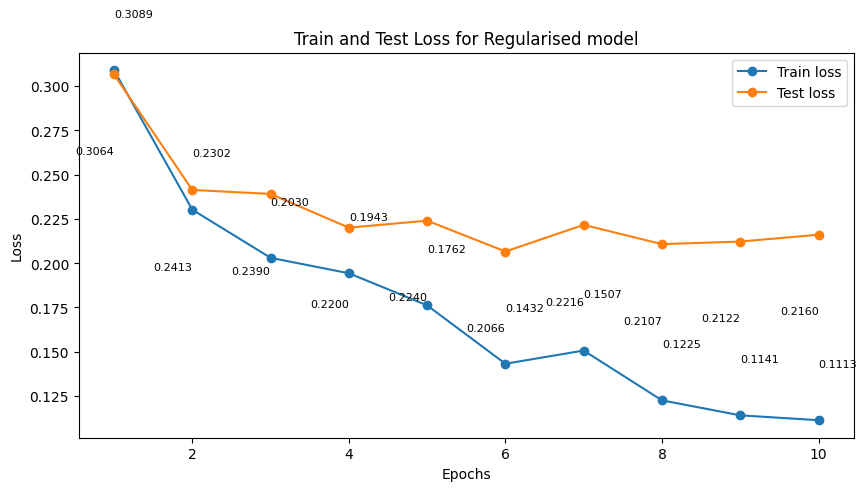

In [23]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

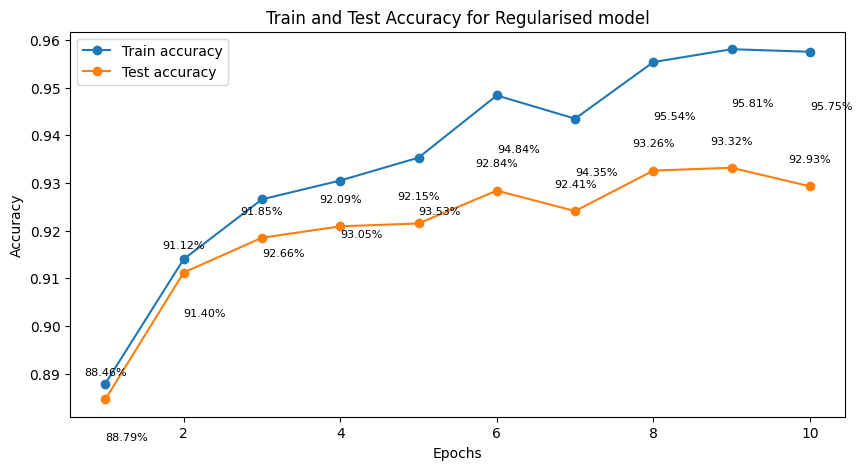

In [24]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [16]:
# Apply only regularisation on the cnn model
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(useRegularization=True).to(device)

epochs = 15 # Increasing the number of epochs by 5 since the learning will be more gradual.

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:

loss: 2.307182  [   64/60000]
loss: 0.545457  [ 6464/60000]
loss: 0.412697  [12864/60000]
loss: 0.284968  [19264/60000]
loss: 0.476108  [25664/60000]
loss: 0.424371  [32064/60000]
loss: 0.252330  [38464/60000]
loss: 0.128152  [44864/60000]
loss: 0.207560  [51264/60000]
loss: 0.131470  [57664/60000]


Epochs:   7%|▋         | 1/15 [00:31<07:17, 31.28s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.217272 

Test Error: 
 Accuracy: 90.2%, Avg loss: 0.263229 

Epoch 2:

loss: 0.134669  [   64/60000]
loss: 0.217828  [ 6464/60000]
loss: 0.233093  [12864/60000]
loss: 0.251436  [19264/60000]
loss: 0.222355  [25664/60000]
loss: 0.102128  [32064/60000]
loss: 0.262029  [38464/60000]
loss: 0.200572  [44864/60000]
loss: 0.145867  [51264/60000]
loss: 0.107268  [57664/60000]


Epochs:  13%|█▎        | 2/15 [01:02<06:42, 30.99s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.158256 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.227444 

Epoch 3:

loss: 0.142305  [   64/60000]
loss: 0.153791  [ 6464/60000]
loss: 0.171001  [12864/60000]
loss: 0.129557  [19264/60000]
loss: 0.117131  [25664/60000]
loss: 0.224266  [32064/60000]
loss: 0.181108  [38464/60000]
loss: 0.176564  [44864/60000]
loss: 0.275989  [51264/60000]
loss: 0.154231  [57664/60000]


Epochs:  20%|██        | 3/15 [01:33<06:11, 30.99s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.124516 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.209225 

Epoch 4:

loss: 0.177074  [   64/60000]
loss: 0.066796  [ 6464/60000]
loss: 0.208036  [12864/60000]
loss: 0.202597  [19264/60000]
loss: 0.248483  [25664/60000]
loss: 0.209295  [32064/60000]
loss: 0.213106  [38464/60000]
loss: 0.178899  [44864/60000]
loss: 0.192154  [51264/60000]
loss: 0.110085  [57664/60000]


Epochs:  27%|██▋       | 4/15 [02:04<05:42, 31.14s/it]

Train Error: 
 Accuracy: 96.9%, Avg loss: 0.083890 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.213363 

Epoch 5:

loss: 0.073575  [   64/60000]
loss: 0.017736  [ 6464/60000]
loss: 0.080517  [12864/60000]
loss: 0.071913  [19264/60000]
loss: 0.129112  [25664/60000]
loss: 0.242406  [32064/60000]
loss: 0.080977  [38464/60000]
loss: 0.115673  [44864/60000]
loss: 0.068154  [51264/60000]
loss: 0.180447  [57664/60000]


Epochs:  33%|███▎      | 5/15 [02:35<05:10, 31.08s/it]

Train Error: 
 Accuracy: 97.2%, Avg loss: 0.076755 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.238692 

Epoch 6:

loss: 0.028354  [   64/60000]
loss: 0.072160  [ 6464/60000]
loss: 0.027273  [12864/60000]
loss: 0.035515  [19264/60000]
loss: 0.061590  [25664/60000]
loss: 0.182180  [32064/60000]
loss: 0.141816  [38464/60000]
loss: 0.029169  [44864/60000]
loss: 0.055837  [51264/60000]
loss: 0.052672  [57664/60000]


Epochs:  40%|████      | 6/15 [03:06<04:40, 31.21s/it]

Train Error: 
 Accuracy: 98.2%, Avg loss: 0.049904 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.273730 

Epoch 7:

loss: 0.075875  [   64/60000]
loss: 0.042374  [ 6464/60000]
loss: 0.012401  [12864/60000]
loss: 0.030169  [19264/60000]
loss: 0.042473  [25664/60000]
loss: 0.073927  [32064/60000]
loss: 0.045509  [38464/60000]
loss: 0.034028  [44864/60000]
loss: 0.196186  [51264/60000]
loss: 0.006562  [57664/60000]


Epochs:  47%|████▋     | 7/15 [03:37<04:09, 31.14s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.040913 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.334454 

Epoch 8:

loss: 0.077780  [   64/60000]
loss: 0.010097  [ 6464/60000]
loss: 0.013824  [12864/60000]
loss: 0.067901  [19264/60000]
loss: 0.027731  [25664/60000]
loss: 0.008726  [32064/60000]
loss: 0.161255  [38464/60000]
loss: 0.018327  [44864/60000]
loss: 0.252491  [51264/60000]
loss: 0.093354  [57664/60000]


Epochs:  53%|█████▎    | 8/15 [04:08<03:37, 31.12s/it]

Train Error: 
 Accuracy: 98.8%, Avg loss: 0.030500 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.346579 

Epoch 9:

loss: 0.030443  [   64/60000]
loss: 0.003163  [ 6464/60000]
loss: 0.005302  [12864/60000]
loss: 0.011472  [19264/60000]
loss: 0.003237  [25664/60000]
loss: 0.064197  [32064/60000]
loss: 0.052902  [38464/60000]
loss: 0.052995  [44864/60000]
loss: 0.039361  [51264/60000]
loss: 0.057754  [57664/60000]


Epochs:  60%|██████    | 9/15 [04:40<03:07, 31.21s/it]

Train Error: 
 Accuracy: 99.2%, Avg loss: 0.023825 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.387142 

Epoch 10:

loss: 0.040873  [   64/60000]
loss: 0.010511  [ 6464/60000]
loss: 0.009742  [12864/60000]
loss: 0.030223  [19264/60000]
loss: 0.002522  [25664/60000]
loss: 0.050981  [32064/60000]
loss: 0.015714  [38464/60000]
loss: 0.061353  [44864/60000]
loss: 0.008178  [51264/60000]
loss: 0.004472  [57664/60000]


Epochs:  67%|██████▋   | 10/15 [05:11<02:35, 31.07s/it]

Train Error: 
 Accuracy: 99.2%, Avg loss: 0.023214 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.402019 

Epoch 11:

loss: 0.062951  [   64/60000]
loss: 0.011358  [ 6464/60000]
loss: 0.196945  [12864/60000]
loss: 0.010430  [19264/60000]
loss: 0.079692  [25664/60000]
loss: 0.010224  [32064/60000]
loss: 0.009728  [38464/60000]
loss: 0.040861  [44864/60000]
loss: 0.025463  [51264/60000]
loss: 0.030333  [57664/60000]


Epochs:  73%|███████▎  | 11/15 [05:42<02:04, 31.17s/it]

Train Error: 
 Accuracy: 99.1%, Avg loss: 0.026368 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.430236 

Epoch 12:

loss: 0.087865  [   64/60000]
loss: 0.014163  [ 6464/60000]
loss: 0.000467  [12864/60000]
loss: 0.024404  [19264/60000]
loss: 0.008033  [25664/60000]
loss: 0.004569  [32064/60000]
loss: 0.008086  [38464/60000]
loss: 0.000435  [44864/60000]
loss: 0.023224  [51264/60000]
loss: 0.038549  [57664/60000]


Epochs:  80%|████████  | 12/15 [06:13<01:33, 31.02s/it]

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.015335 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.445328 

Epoch 13:

loss: 0.000333  [   64/60000]
loss: 0.069822  [ 6464/60000]
loss: 0.002766  [12864/60000]
loss: 0.066212  [19264/60000]
loss: 0.022845  [25664/60000]
loss: 0.002013  [32064/60000]
loss: 0.166600  [38464/60000]
loss: 0.002294  [44864/60000]
loss: 0.014289  [51264/60000]
loss: 0.102105  [57664/60000]


Epochs:  87%|████████▋ | 13/15 [06:44<01:02, 31.10s/it]

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.013868 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.418709 

Epoch 14:

loss: 0.029874  [   64/60000]
loss: 0.016477  [ 6464/60000]
loss: 0.047759  [12864/60000]
loss: 0.217000  [19264/60000]
loss: 0.075707  [25664/60000]
loss: 0.011532  [32064/60000]
loss: 0.022617  [38464/60000]
loss: 0.093822  [44864/60000]
loss: 0.173449  [51264/60000]
loss: 0.062582  [57664/60000]


Epochs:  93%|█████████▎| 14/15 [07:15<00:31, 31.18s/it]

Train Error: 
 Accuracy: 99.4%, Avg loss: 0.018691 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.499984 

Epoch 15:

loss: 0.006853  [   64/60000]
loss: 0.002656  [ 6464/60000]
loss: 0.005488  [12864/60000]
loss: 0.005594  [19264/60000]
loss: 0.024635  [25664/60000]
loss: 0.007080  [32064/60000]
loss: 0.003016  [38464/60000]
loss: 0.024294  [44864/60000]
loss: 0.043983  [51264/60000]
loss: 0.014109  [57664/60000]


Epochs: 100%|██████████| 15/15 [07:46<00:00, 31.13s/it]

Train Error: 
 Accuracy: 99.6%, Avg loss: 0.011850 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.485208 

Done training!


Plotting metrics

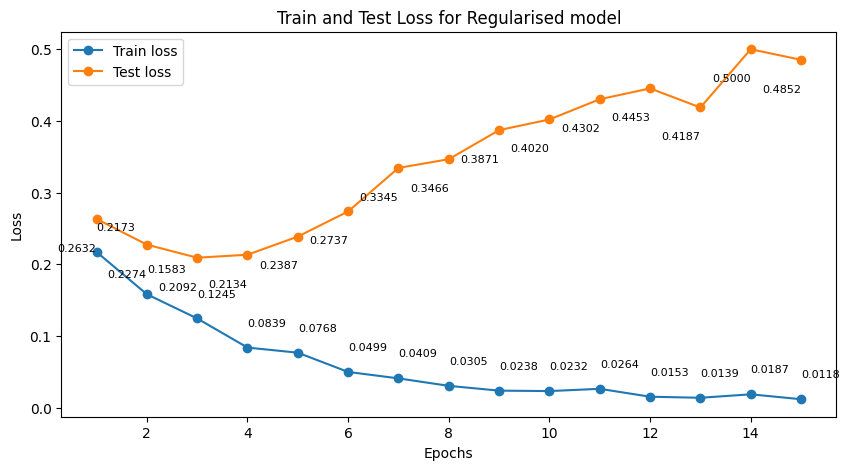

In [17]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

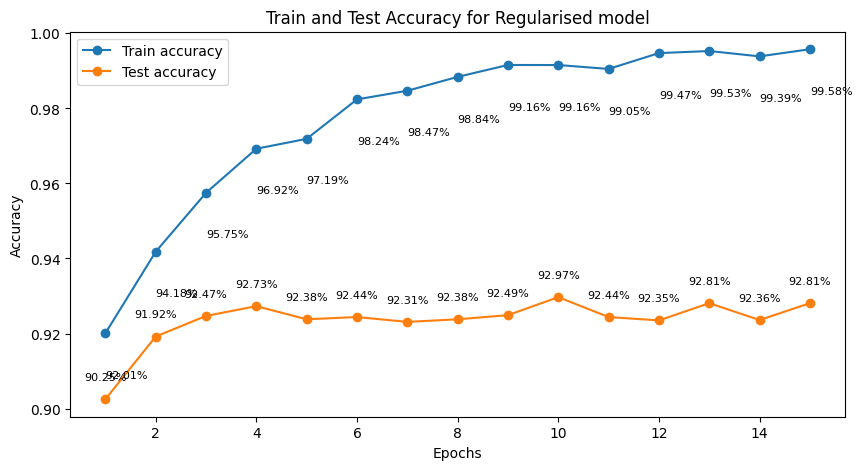

In [18]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [19]:
# Apply only weight decay technique
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(useRegularization=False).to(device)
epochs = 15 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:

loss: 2.301249  [   64/60000]
loss: 0.463821  [ 6464/60000]
loss: 0.590331  [12864/60000]
loss: 0.573838  [19264/60000]
loss: 0.350390  [25664/60000]
loss: 0.281005  [32064/60000]
loss: 0.347382  [38464/60000]
loss: 0.261214  [44864/60000]
loss: 0.296194  [51264/60000]
loss: 0.248824  [57664/60000]


Epochs:   7%|▋         | 1/15 [00:32<07:28, 32.03s/it]

Train Error: 
 Accuracy: 88.3%, Avg loss: 0.310921 

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.343420 

Epoch 2:

loss: 0.329513  [   64/60000]
loss: 0.130092  [ 6464/60000]
loss: 0.205793  [12864/60000]
loss: 0.313187  [19264/60000]
loss: 0.240482  [25664/60000]
loss: 0.152137  [32064/60000]
loss: 0.275903  [38464/60000]
loss: 0.285346  [44864/60000]
loss: 0.266004  [51264/60000]
loss: 0.165214  [57664/60000]


Epochs:  13%|█▎        | 2/15 [01:02<06:46, 31.27s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.224694 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.265688 

Epoch 3:

loss: 0.173238  [   64/60000]
loss: 0.163705  [ 6464/60000]
loss: 0.135298  [12864/60000]
loss: 0.180136  [19264/60000]
loss: 0.208119  [25664/60000]
loss: 0.287126  [32064/60000]
loss: 0.206440  [38464/60000]
loss: 0.179049  [44864/60000]
loss: 0.315686  [51264/60000]
loss: 0.142646  [57664/60000]


Epochs:  20%|██        | 3/15 [01:34<06:15, 31.31s/it]

Train Error: 
 Accuracy: 92.8%, Avg loss: 0.202495 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.245934 

Epoch 4:

loss: 0.126349  [   64/60000]
loss: 0.230744  [ 6464/60000]
loss: 0.230969  [12864/60000]
loss: 0.118678  [19264/60000]
loss: 0.277539  [25664/60000]
loss: 0.411532  [32064/60000]
loss: 0.352330  [38464/60000]
loss: 0.210031  [44864/60000]
loss: 0.189742  [51264/60000]
loss: 0.132232  [57664/60000]


Epochs:  27%|██▋       | 4/15 [02:04<05:41, 31.08s/it]

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.194213 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.248236 

Epoch 5:

loss: 0.176934  [   64/60000]
loss: 0.228894  [ 6464/60000]
loss: 0.101764  [12864/60000]
loss: 0.125833  [19264/60000]
loss: 0.111307  [25664/60000]
loss: 0.296248  [32064/60000]
loss: 0.157479  [38464/60000]
loss: 0.237005  [44864/60000]
loss: 0.190157  [51264/60000]
loss: 0.161826  [57664/60000]


Epochs:  33%|███▎      | 5/15 [02:39<05:22, 32.25s/it]

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.168796 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.223386 

Epoch 6:

loss: 0.150327  [   64/60000]
loss: 0.226109  [ 6464/60000]
loss: 0.251042  [12864/60000]
loss: 0.155806  [19264/60000]
loss: 0.173315  [25664/60000]
loss: 0.238878  [32064/60000]
loss: 0.121881  [38464/60000]
loss: 0.218258  [44864/60000]
loss: 0.211945  [51264/60000]
loss: 0.060591  [57664/60000]


Epochs:  40%|████      | 6/15 [03:12<04:52, 32.45s/it]

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.157837 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.212210 

Epoch 7:

loss: 0.101125  [   64/60000]
loss: 0.240565  [ 6464/60000]
loss: 0.202062  [12864/60000]
loss: 0.088069  [19264/60000]
loss: 0.137963  [25664/60000]
loss: 0.142155  [32064/60000]
loss: 0.167720  [38464/60000]
loss: 0.198208  [44864/60000]
loss: 0.305376  [51264/60000]
loss: 0.244339  [57664/60000]


Epochs:  47%|████▋     | 7/15 [03:43<04:16, 32.06s/it]

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.164453 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.222994 

Epoch 8:

loss: 0.236243  [   64/60000]
loss: 0.132382  [ 6464/60000]
loss: 0.137796  [12864/60000]
loss: 0.078778  [19264/60000]
loss: 0.205912  [25664/60000]
loss: 0.136404  [32064/60000]
loss: 0.157584  [38464/60000]
loss: 0.192020  [44864/60000]
loss: 0.164904  [51264/60000]
loss: 0.293413  [57664/60000]


Epochs:  53%|█████▎    | 8/15 [04:14<03:41, 31.66s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.163355 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.223000 

Epoch 9:

loss: 0.120659  [   64/60000]
loss: 0.166175  [ 6464/60000]
loss: 0.140904  [12864/60000]
loss: 0.203537  [19264/60000]
loss: 0.204494  [25664/60000]
loss: 0.155193  [32064/60000]
loss: 0.173329  [38464/60000]
loss: 0.138788  [44864/60000]
loss: 0.178373  [51264/60000]
loss: 0.129870  [57664/60000]


Epochs:  60%|██████    | 9/15 [04:45<03:08, 31.48s/it]

Train Error: 
 Accuracy: 95.2%, Avg loss: 0.144775 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.212036 

Epoch 10:

loss: 0.168377  [   64/60000]
loss: 0.084899  [ 6464/60000]
loss: 0.131223  [12864/60000]
loss: 0.090452  [19264/60000]
loss: 0.104035  [25664/60000]
loss: 0.137198  [32064/60000]
loss: 0.148252  [38464/60000]
loss: 0.185219  [44864/60000]
loss: 0.148388  [51264/60000]
loss: 0.125504  [57664/60000]


Epochs:  67%|██████▋   | 10/15 [05:15<02:35, 31.10s/it]

Train Error: 
 Accuracy: 95.3%, Avg loss: 0.136335 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.209893 

Epoch 11:

loss: 0.049535  [   64/60000]
loss: 0.149728  [ 6464/60000]
loss: 0.040439  [12864/60000]
loss: 0.075570  [19264/60000]
loss: 0.031319  [25664/60000]
loss: 0.105718  [32064/60000]
loss: 0.091038  [38464/60000]
loss: 0.098944  [44864/60000]
loss: 0.203830  [51264/60000]
loss: 0.028001  [57664/60000]


Epochs:  73%|███████▎  | 11/15 [05:46<02:04, 31.09s/it]

Train Error: 
 Accuracy: 95.1%, Avg loss: 0.135512 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.218944 

Epoch 12:

loss: 0.057494  [   64/60000]
loss: 0.198975  [ 6464/60000]
loss: 0.184292  [12864/60000]
loss: 0.304873  [19264/60000]
loss: 0.177056  [25664/60000]
loss: 0.060030  [32064/60000]
loss: 0.138619  [38464/60000]
loss: 0.135695  [44864/60000]
loss: 0.244548  [51264/60000]
loss: 0.129660  [57664/60000]


Epochs:  80%|████████  | 12/15 [06:16<01:32, 30.85s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.122510 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.210340 

Epoch 13:

loss: 0.087892  [   64/60000]
loss: 0.204712  [ 6464/60000]
loss: 0.135977  [12864/60000]
loss: 0.159098  [19264/60000]
loss: 0.083729  [25664/60000]
loss: 0.183072  [32064/60000]
loss: 0.199732  [38464/60000]
loss: 0.214940  [44864/60000]
loss: 0.145606  [51264/60000]
loss: 0.160859  [57664/60000]


Epochs:  87%|████████▋ | 13/15 [06:47<01:01, 30.87s/it]

Train Error: 
 Accuracy: 95.7%, Avg loss: 0.118436 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.214212 

Epoch 14:

loss: 0.143313  [   64/60000]
loss: 0.125623  [ 6464/60000]
loss: 0.175615  [12864/60000]
loss: 0.094135  [19264/60000]
loss: 0.074245  [25664/60000]
loss: 0.050925  [32064/60000]
loss: 0.162036  [38464/60000]
loss: 0.186600  [44864/60000]
loss: 0.072061  [51264/60000]
loss: 0.178988  [57664/60000]


Epochs:  93%|█████████▎| 14/15 [07:18<00:30, 30.75s/it]

Train Error: 
 Accuracy: 95.4%, Avg loss: 0.124946 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.227697 

Epoch 15:

loss: 0.149889  [   64/60000]
loss: 0.137595  [ 6464/60000]
loss: 0.126098  [12864/60000]
loss: 0.171232  [19264/60000]
loss: 0.165514  [25664/60000]
loss: 0.087678  [32064/60000]
loss: 0.104890  [38464/60000]
loss: 0.077935  [44864/60000]
loss: 0.112540  [51264/60000]
loss: 0.118518  [57664/60000]


Epochs: 100%|██████████| 15/15 [07:49<00:00, 31.28s/it]

Train Error: 
 Accuracy: 95.7%, Avg loss: 0.119565 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.225177 

Done training!


Plotting metrics

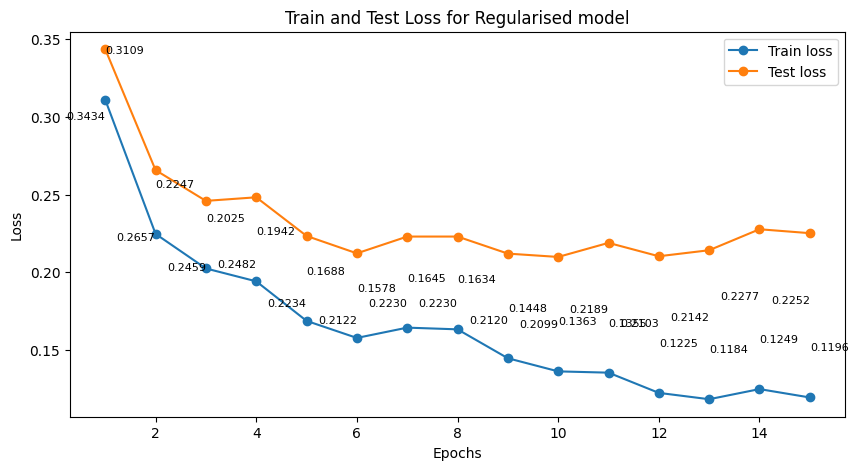

In [20]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

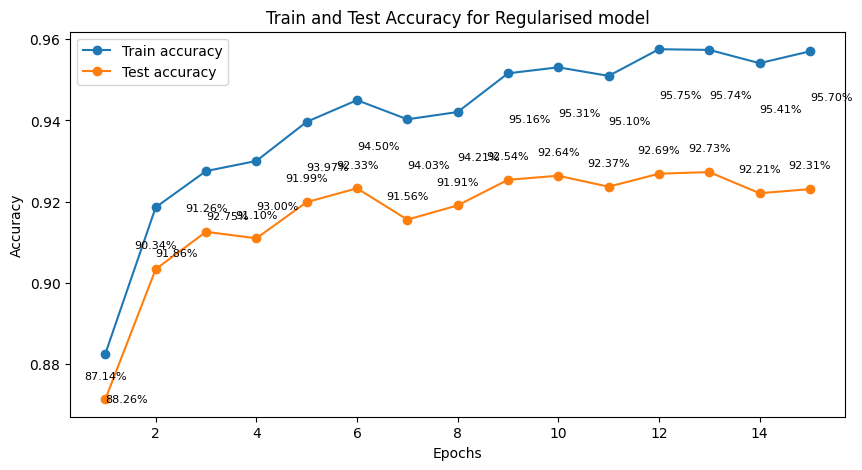

In [21]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [25]:
# Apply all regularisation techniques
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion(useRegularization=True).to(device)

epochs = 15 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:

loss: 2.299535  [   64/60000]
loss: 0.735078  [ 6464/60000]
loss: 0.545450  [12864/60000]
loss: 0.484635  [19264/60000]
loss: 0.437738  [25664/60000]
loss: 0.455761  [32064/60000]
loss: 0.355285  [38464/60000]
loss: 0.445825  [44864/60000]
loss: 0.404526  [51264/60000]
loss: 0.286622  [57664/60000]


Epochs:   7%|▋         | 1/15 [00:46<10:45, 46.11s/it]

Train Error: 
 Accuracy: 87.9%, Avg loss: 0.328922 

Test Error: 
 Accuracy: 87.7%, Avg loss: 0.338073 

Epoch 2:

loss: 0.200035  [   64/60000]
loss: 0.195332  [ 6464/60000]
loss: 0.061931  [12864/60000]
loss: 0.222196  [19264/60000]
loss: 0.151537  [25664/60000]
loss: 0.397709  [32064/60000]
loss: 0.396568  [38464/60000]
loss: 0.285395  [44864/60000]
loss: 0.301488  [51264/60000]
loss: 0.185691  [57664/60000]


Epochs:  13%|█▎        | 2/15 [01:31<09:52, 45.60s/it]

Train Error: 
 Accuracy: 89.3%, Avg loss: 0.296793 

Test Error: 
 Accuracy: 89.6%, Avg loss: 0.290528 

Epoch 3:

loss: 0.263381  [   64/60000]
loss: 0.295536  [ 6464/60000]
loss: 0.382853  [12864/60000]
loss: 0.219023  [19264/60000]
loss: 0.365798  [25664/60000]
loss: 0.134316  [32064/60000]
loss: 0.356228  [38464/60000]
loss: 0.320448  [44864/60000]
loss: 0.263618  [51264/60000]
loss: 0.263219  [57664/60000]


Epochs:  20%|██        | 3/15 [02:16<09:07, 45.59s/it]

Train Error: 
 Accuracy: 90.8%, Avg loss: 0.252503 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.265724 

Epoch 4:

loss: 0.182888  [   64/60000]
loss: 0.217413  [ 6464/60000]
loss: 0.429941  [12864/60000]
loss: 0.178909  [19264/60000]
loss: 0.571810  [25664/60000]
loss: 0.237285  [32064/60000]
loss: 0.240186  [38464/60000]
loss: 0.198483  [44864/60000]
loss: 0.207937  [51264/60000]
loss: 0.233468  [57664/60000]


Epochs:  27%|██▋       | 4/15 [03:02<08:20, 45.54s/it]

Train Error: 
 Accuracy: 90.1%, Avg loss: 0.269350 

Test Error: 
 Accuracy: 89.6%, Avg loss: 0.295099 

Epoch 5:

loss: 0.345763  [   64/60000]
loss: 0.081671  [ 6464/60000]
loss: 0.215745  [12864/60000]
loss: 0.328792  [19264/60000]
loss: 0.300294  [25664/60000]
loss: 0.308058  [32064/60000]
loss: 0.249535  [38464/60000]
loss: 0.189625  [44864/60000]
loss: 0.188288  [51264/60000]
loss: 0.145447  [57664/60000]


Epochs:  33%|███▎      | 5/15 [03:47<07:34, 45.41s/it]

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.250117 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.264148 

Epoch 6:

loss: 0.369563  [   64/60000]
loss: 0.167691  [ 6464/60000]
loss: 0.106238  [12864/60000]
loss: 0.538469  [19264/60000]
loss: 0.262890  [25664/60000]
loss: 0.244563  [32064/60000]
loss: 0.245135  [38464/60000]
loss: 0.243765  [44864/60000]
loss: 0.195136  [51264/60000]
loss: 0.147682  [57664/60000]


Epochs:  40%|████      | 6/15 [04:33<06:49, 45.53s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.236577 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.251864 

Epoch 7:

loss: 0.294421  [   64/60000]
loss: 0.190901  [ 6464/60000]
loss: 0.367821  [12864/60000]
loss: 0.296900  [19264/60000]
loss: 0.154756  [25664/60000]
loss: 0.268294  [32064/60000]
loss: 0.136789  [38464/60000]
loss: 0.247092  [44864/60000]
loss: 0.242814  [51264/60000]
loss: 0.179507  [57664/60000]


Epochs:  47%|████▋     | 7/15 [05:19<06:05, 45.66s/it]

Train Error: 
 Accuracy: 92.2%, Avg loss: 0.215107 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.235974 

Epoch 8:

loss: 0.199048  [   64/60000]
loss: 0.247236  [ 6464/60000]
loss: 0.255507  [12864/60000]
loss: 0.362184  [19264/60000]
loss: 0.121323  [25664/60000]
loss: 0.167116  [32064/60000]
loss: 0.297541  [38464/60000]
loss: 0.172749  [44864/60000]
loss: 0.326083  [51264/60000]
loss: 0.267972  [57664/60000]


Epochs:  53%|█████▎    | 8/15 [06:04<05:19, 45.68s/it]

Train Error: 
 Accuracy: 91.8%, Avg loss: 0.223124 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.232269 

Epoch 9:

loss: 0.190661  [   64/60000]
loss: 0.301937  [ 6464/60000]
loss: 0.142807  [12864/60000]
loss: 0.267559  [19264/60000]
loss: 0.271350  [25664/60000]
loss: 0.253232  [32064/60000]
loss: 0.217116  [38464/60000]
loss: 0.184893  [44864/60000]
loss: 0.220171  [51264/60000]
loss: 0.236486  [57664/60000]


Epochs:  60%|██████    | 9/15 [06:49<04:31, 45.31s/it]

Train Error: 
 Accuracy: 92.1%, Avg loss: 0.216159 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.237500 

Epoch 10:

loss: 0.094181  [   64/60000]
loss: 0.226400  [ 6464/60000]
loss: 0.160579  [12864/60000]
loss: 0.353576  [19264/60000]
loss: 0.187323  [25664/60000]
loss: 0.134535  [32064/60000]
loss: 0.129713  [38464/60000]
loss: 0.299508  [44864/60000]
loss: 0.235139  [51264/60000]
loss: 0.188216  [57664/60000]


Epochs:  67%|██████▋   | 10/15 [07:35<03:46, 45.38s/it]

Train Error: 
 Accuracy: 92.3%, Avg loss: 0.208633 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.227024 

Epoch 11:

loss: 0.236468  [   64/60000]
loss: 0.153914  [ 6464/60000]
loss: 0.152252  [12864/60000]
loss: 0.391396  [19264/60000]
loss: 0.137505  [25664/60000]
loss: 0.120999  [32064/60000]
loss: 0.254030  [38464/60000]
loss: 0.416215  [44864/60000]
loss: 0.181831  [51264/60000]
loss: 0.301398  [57664/60000]


Epochs:  73%|███████▎  | 11/15 [08:20<03:01, 45.42s/it]

Train Error: 
 Accuracy: 92.3%, Avg loss: 0.211722 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.230776 

Epoch 12:

loss: 0.233715  [   64/60000]
loss: 0.246645  [ 6464/60000]
loss: 0.211528  [12864/60000]
loss: 0.206691  [19264/60000]
loss: 0.182996  [25664/60000]
loss: 0.167429  [32064/60000]
loss: 0.155582  [38464/60000]
loss: 0.307143  [44864/60000]
loss: 0.317092  [51264/60000]
loss: 0.209291  [57664/60000]


Epochs:  80%|████████  | 12/15 [09:06<02:16, 45.48s/it]

Train Error: 
 Accuracy: 92.7%, Avg loss: 0.201425 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.219483 

Epoch 13:

loss: 0.133239  [   64/60000]
loss: 0.156234  [ 6464/60000]
loss: 0.309595  [12864/60000]
loss: 0.254834  [19264/60000]
loss: 0.081963  [25664/60000]
loss: 0.387222  [32064/60000]
loss: 0.281661  [38464/60000]
loss: 0.215111  [44864/60000]
loss: 0.170622  [51264/60000]
loss: 0.566189  [57664/60000]


Epochs:  87%|████████▋ | 13/15 [09:50<01:30, 45.09s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.204512 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.232538 

Epoch 14:

loss: 0.207366  [   64/60000]
loss: 0.204722  [ 6464/60000]
loss: 0.214134  [12864/60000]
loss: 0.187972  [19264/60000]
loss: 0.196988  [25664/60000]
loss: 0.099721  [32064/60000]
loss: 0.238126  [38464/60000]
loss: 0.290205  [44864/60000]
loss: 0.230904  [51264/60000]
loss: 0.145300  [57664/60000]


Epochs:  93%|█████████▎| 14/15 [10:35<00:45, 45.14s/it]

Train Error: 
 Accuracy: 92.1%, Avg loss: 0.215808 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.231715 

Epoch 15:

loss: 0.298957  [   64/60000]
loss: 0.144590  [ 6464/60000]
loss: 0.095459  [12864/60000]
loss: 0.229513  [19264/60000]
loss: 0.328544  [25664/60000]
loss: 0.234907  [32064/60000]
loss: 0.234215  [38464/60000]
loss: 0.132398  [44864/60000]
loss: 0.213483  [51264/60000]
loss: 0.099385  [57664/60000]


Epochs: 100%|██████████| 15/15 [11:21<00:00, 45.40s/it]

Train Error: 
 Accuracy: 92.8%, Avg loss: 0.197964 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.222238 

Done training!


Plotting metrics

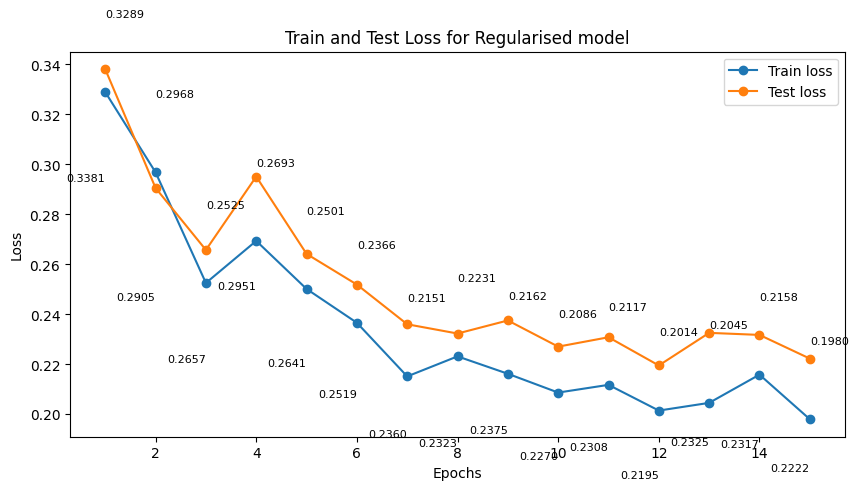

In [26]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

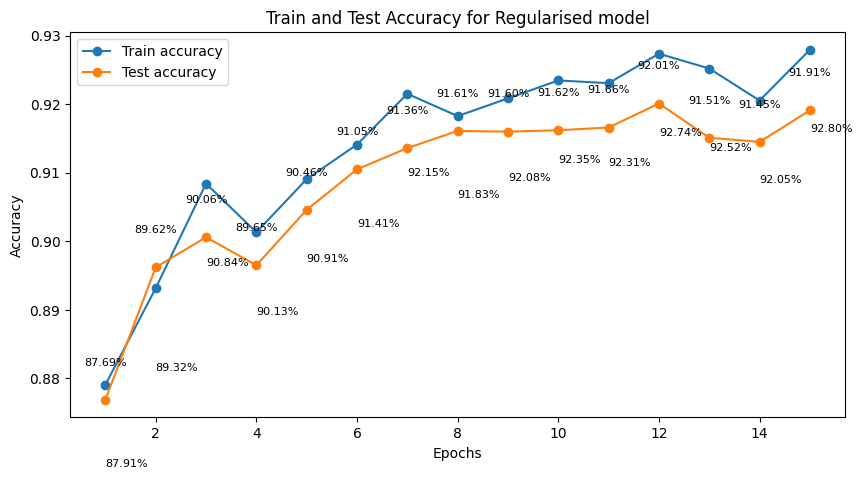

In [27]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>I found this exercise really interesting as we could clearly see that overfitting was happening in the training of models on this dataset, this was evident with the discrepancy between training and testing accuracy. where the training accuracy was much higher. This implementation of different techniques to reduce overfitting was very insightful and gave great context into how they work in practice.</font>

